## Import Libraries

In [1]:
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg 
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog


In [21]:
import json
import os
import sys
import random 
import PIL
import matplotlib.pyplot as plt 
import cv2
import numpy as np
from matplotlib.patches import Rectangle


## Global Variables


In [3]:
ROOT = os.path.abspath('../')
DATA_FOLDER = 'data/plates_with_json'
CONFIG = 'config'
WEIGHTS = 'weights'
DEVICE = 'cpu'

## Helper Functions

In [4]:

def get_carplate_dicts(mode):
    path = os.path.join(ROOT, DATA_FOLDER)
    json_file = os.path.join(path, "dataset_mask_full_no_aug.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)
    
    dataset_dicts = []
    dataset_len = len(list(imgs_anns['_via_img_metadata'].values()))
    dataset = list(imgs_anns['_via_img_metadata'].values())
    if mode == 'train':
        dataset = dataset[:dataset_len - int(dataset_len*0.1)]
    elif mode == 'val':
        dataset = dataset[dataset_len - int(dataset_len*0.1):]

    print(len(dataset))
    for idx, v in enumerate(list(dataset)):
        record = {}
        
        filename = os.path.join(path, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for anno in annos:
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts



## Prepare dataset

In [5]:
DatasetCatalog.register("carplate_train", lambda x='train':  get_carplate_dicts(x))
DatasetCatalog.register("carplate_val", lambda x='val':  get_carplate_dicts(x))
MetadataCatalog.get("carplate_val").set(thing_classes=["carplate"])
carplate_metadata = MetadataCatalog.get("carplate_train")

MetadataCatalog.get("carplate_val").set(evaluator_type='coco')

Metadata(evaluator_type='coco', name='carplate_val', thing_classes=['carplate'])

## Inference

In [7]:
cfg = get_cfg()
cfg.MODEL.DEVICE = DEVICE
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "centermask_model_final_20200522.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("carplate_val", )
predictor = DefaultPredictor(cfg)

In [27]:
import time
times = []
im = cv2.imread(d["file_name"])
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

KeyboardInterrupt: 

186
Instances(num_instances=1, image_height=960, image_width=1280, fields=[pred_boxes: Boxes(tensor([[   0.,    0., 1280.,  960.]])), scores: tensor([1.]), pred_classes: tensor([26])])


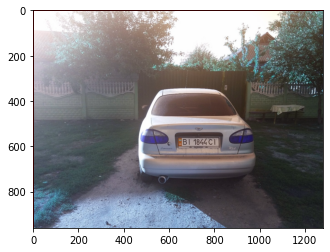

Instances(num_instances=1, image_height=1920, image_width=1080, fields=[pred_boxes: Boxes(tensor([[   0.,    0., 1080., 1920.]])), scores: tensor([1.]), pred_classes: tensor([26])])


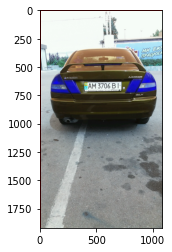

Instances(num_instances=0, image_height=932, image_width=1242, fields=[pred_boxes: Boxes(tensor([], size=(0, 4))), scores: tensor([]), pred_classes: tensor([], dtype=torch.int64)])


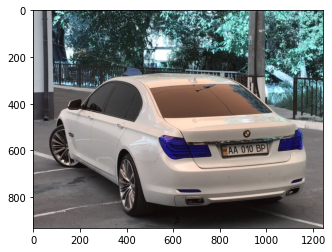

In [26]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_carplate_dicts('val')
for d in dataset_dicts[0:3]:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=carplate_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    boxes = outputs["instances"].get_fields()['pred_boxes'].tensor.numpy()
    plt.imshow(im)
    
    ax = plt.gca()

    # Create a Rectangle patch
    print(outputs["instances"])
    for box in boxes:
        rect = Rectangle((box[0],box[1]),box[2],box[3],linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
#     v = v.draw_instance_predictions(outputs["instances"].to(DEVICE))
#     plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()